# <span style="color:red"> Laboratorio di Simulazione Numerica (LSN) </span>

#### Luca Camillini - Luglio 2021

## <span style="color:blue">  Esercitazione 5</span>

### Esercizio 05.1

In questo esercizio vogliamo campionare, tramite algoritmo di Metropolis, le funzioni d'onda del *Ground State (GS)* e *primo stato eccitato*, per un atomo di idrogeno. Più precisamente siamo interessati ai quadrati dei moduli di tali funzioni, in quanto sono l'oggetto con un reale significato fisico. Mostreremo poi le stime del valor medio della posizione per i due stati, ottenute tramite data blocking, in funzione del numero di blocchi.

#### Le funzioni d'onda dell'atomo di idrogeno.

Risolvendo l'equazione di Schroedinger per l'elettrone legato attorno a un nucleo fisso di idrogeno si ottengono le seguenti funzioni d'onda per il *GS* e il *primo stato eccitato*:
$$
\Psi_{1,0,0}(r,\theta,\phi)=
\frac{a_0^{-3/2}}{\sqrt{\pi}} e^{-r/a_0} 
$$
$$
\Psi_{2,1,0}(r,\theta,\phi)=
\frac{a_0^{-5/2}}{8}\sqrt{\frac{2}{\pi}} r e^{-r/2a_0} \cos(\theta)
$$
dalle quali si ricava tramite integrazione che 
$$
\left\langle r \right\rangle_{\Psi_{1,0,0}} = \frac{3}{2}a_0
\quad
\left\langle r \right\rangle_{\Psi_{2,1,0}} = 5 a_0
$$
dove $a_{0}=4\pi\epsilon_0\hbar^2/m_e e^2=0.0529$ è il raggio di Bohr.
Le densità di probabilità che vogliamo campionare sono rispettivamente $|\Psi_{1,0,0}(x,y,z)|^2$ e $|\Psi_{2,1,0}(x,y,z)|^2$. **N.B.: nel codice implementato tali funzioni vengono campionate in coordinate cartesiane**. 

#### Algoritmo di Metropolis: come funziona

L'algoritmo di Metropolis è un algoritmo per campionare distribuzioni di probabilità qualsiasi, anche particolarmente complicate, tramite procedimento di *Accept/Reject*.

Consideriamo un processo stocastico e $x$ e $y$ due stati in cui il sistema si può trovare (per esempio due posizioni di un RW). Per questo tipo di processo sono definite la probabilità di trovarsi in $x$, $p(x)$, e la probabilità di saltare da $x$ a $y$, nota come _Matrice di trasferimento_, $K\left(y|x\right)$ (di fatto è una probabilità condizionale). Se di solito il problema di un processo stocastico è ricavare $p(x)$ da un'equazione differenziale che coinvolge $K\left(y|x\right)$ (ad esempio la _Master equation_), l'algoritmo di Metropolis ci permette di risolvere il problema inverso: data una certa $p(x)$ ricavare quella $K\left(y|x\right)$ che permetta il corretto campionamento della $p(x)$.

Passiamo ora nello specifico del campionamento. Sia $x_{n}$ la successione di valori che campioniamo e che sono distribuiti secondo $p(x)$. A ognuno è associata una probabilità di essere estratto: $d_{n}\left(x_{n}\right)$, assumiamo che $\lim_{n\to\infty} d_{n}(x) = p(x)$. Inoltre, dato che $p(x) = \int K\left(y|x\right)p(y)\,dy$, segue che $p(x) = \lim_{n\to\infty} \int K\left(y|x\right)d_{n}(x)\,dy$. Quindi, campionando la variabile la prima volta con $d_{1}(x)$, se ho scelto una giusta distribuzione e conosco il $K$, posso proseguire senza problemi sicuro di arrivare a $p(x)$. Ora noi vogliamo fare il contrario: data la p quale K dobbiamo scegliere? Per rispondere a questa domanda assumiamo che valga il principio del bilancio dettagliato: $K\left(y|x\right)p(y) = K\left(x|y\right)p(x)$. Questo rende p invariante rispetto alla scelta di K e quindi possiamo costruirlo come vogliamo.

L'idea ora è semplice: $K = T \times A$, dove ho una matrice di trasferimento che propone un passaggio e una probabilità A di accettazione, purché la K risultante soddisfi il bilancio dettagliato. Si può dimostrare che ciò è valido e quindi è possibile scegliere arbitrariamente $T$ e $A$; al limite, se si sceglie male, si paga in efficienza nell'algoritmo. Nel nostro caso poniamo $T(x|y)=T(y|x)$ e $A = \min\left(1,\frac{p(x)}{p(y)}\right)$ per un salto da $x$ a $y$. 

#### Ciclo dell'algoritmo

Procediamo nel seguente modo: 
1. si genera una posizione $x$,
2. si propone una nuova posizione $y$,
3. si valuta $A = min(1, \frac{p(y)}{p(x)})$,
4. viene generato un numero casuale $h \in [0,1)$,
    1. h > A si accetta la mossa, da $x$ si passa a $y$
    2. h < A si rifiuta la mossa rimanendo in $x$.
    
**Correlazione ed efficienza**

L'algoritmo di Metropolis ha due proprietà a cui fare attenzione. La prima è che se le mosse proposte non si discostano di molto dal punto in cui ci si trova verranno facilmente accettate ma possono presentare delle correlazioni. Al tempo stesso mosse grandi daranno luogo a risultati scorrelati ma possono portare a casi in cui $\frac{p(y)}{p(x)}\ll 1$, compromettendo l'efficienza dell'algoritmo. Per questo si farà uso di seguito della ***regola empirica del $50\%$***: essa afferma che l'algoritmo lavora bene facendo passi tali che per il $50\%$ vengono accettati, per il $50\%$ rifiutati.

#### Codice
Innanzitutto vi è un primo step di inizializzazione del sistema: l'atomo di idrogeno è posto nell'origine degli assi, viene individuato un punto $\vec{r}_{old}$ in una regione circostante il nucleo, facendo attenzione che non si tratti di un **punto a probabilità nulla**. Viene generato in maniera casuale un passo $d\vec{r}$ ottenendo il nuovo punto candidato $\vec{r}_{new} = \vec{r}_{old} + d\vec{r}$ in cui far saltare l'elettrone. Dopodiché viene valutata $A$ e, tramite il generatore di numeri casuali uniforme, si accetta o rifiuta la mossa proposta. Se la mossa è accettata allora $\vec{r}_{old} = \vec{r}_{new}$. Per ogni passo, sia che la proposta venga accettata, sia che non venga accettata, viene valutata la distanza dal nucleo (cioè l'origine). 

Il codice è implementato in modo tale da poter estrarre la percentuale di accettazione delle mosse, affinché si possa controllare che la regola sopra esposta sia rispettata.

**Tutti i risultati riportati sono in unità di $a_{0}$**

### Ground State (GS)
Per simulare il GS dell'atomo di idrogeno e calcolare $\left\langle r \right\rangle_{\Psi_{1,0,0}}$, mantenendo il rate di accettazione attorno al $50\%$, $|d\vec{r}|$ è distribuito uniformemente tra $0$ e $1.2\times a_{0}$. Vengono eseguite $10^{6}$ misure divise su $100$ blocchi. Per il primo blocco l'incertezza statistica è posta pari a $0$.

#### Equilibrazione

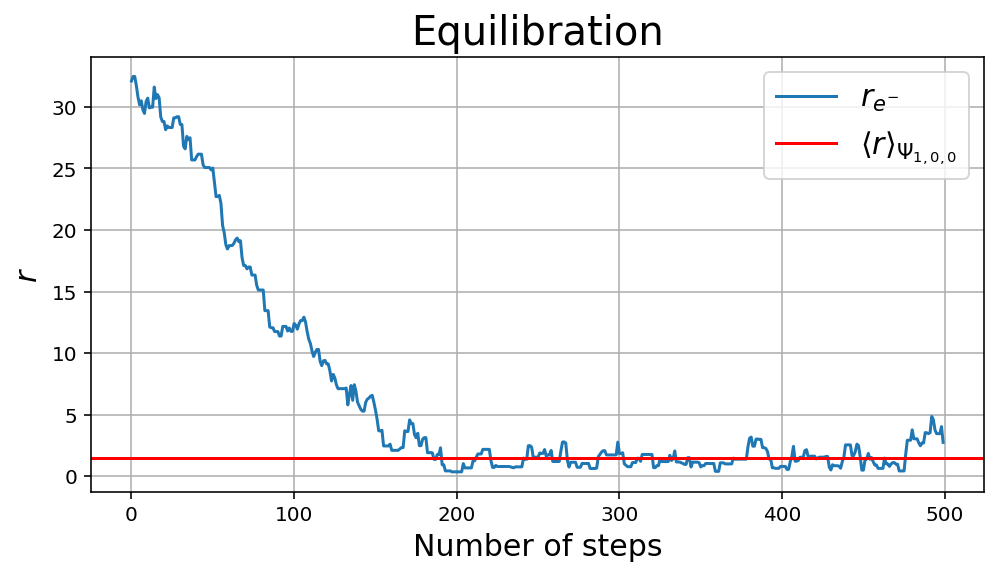

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

%config InlineBackend.figure_format = 'retina'

r_eq = pd.read_table("Esercizio 5/ground state/equilibration.dat", header = None)

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(r_eq, label=r"$r_{e^{-}}$")
ax.axhline(1.5, color='red', label=r"$\left\langle r \right\rangle_{\Psi_{1,0,0}}$")
ax.set_ylabel("$r$", size = 15)
ax.set_xlabel("Number of steps", size = 15)
ax.set_title("Equilibration", size=20)
ax.legend(prop={'size': 15})
ax.grid()

La distanza iniziale dell'elettrone è molto maggiore rispetto a quella di equilibrio. Per questo è necessario far equilibrare il sistema, ovvero permettere all'elettrone di raggiungere quelle regioni dove la funzione d'onda è massima. 

#### Equilibrio

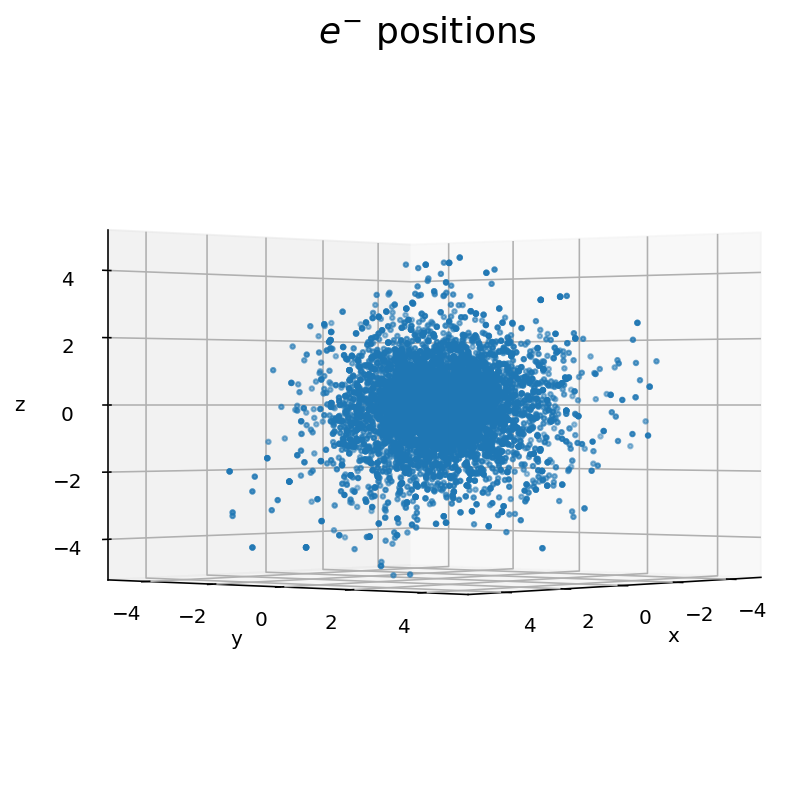

In [2]:
r = np.loadtxt('Esercizio 5/ground state/conf.xyz')

r = pd.DataFrame(r)
    
lim = [-5,5]
fig = plt.figure(figsize=(5,5))
ax = Axes3D(fig)
ax.scatter(r[0], r[1], r[2], marker='.')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.axes.set_xlim(lim)
ax.axes.set_ylim(lim)
ax.axes.set_zlim(lim)
ax.set_title("$e^{-}$ positions", size = 18)
ax.view_init(0,40)
plt.show()

Nell'immagine sopra riportata si possono osservare le diverse posizioni assunte dall'elettrone, una volta che il sistema è stato equilibrato. Come noto dai risultati teorici, il *GS* mostra simmetria sferica.

#### Valor medio della posizione

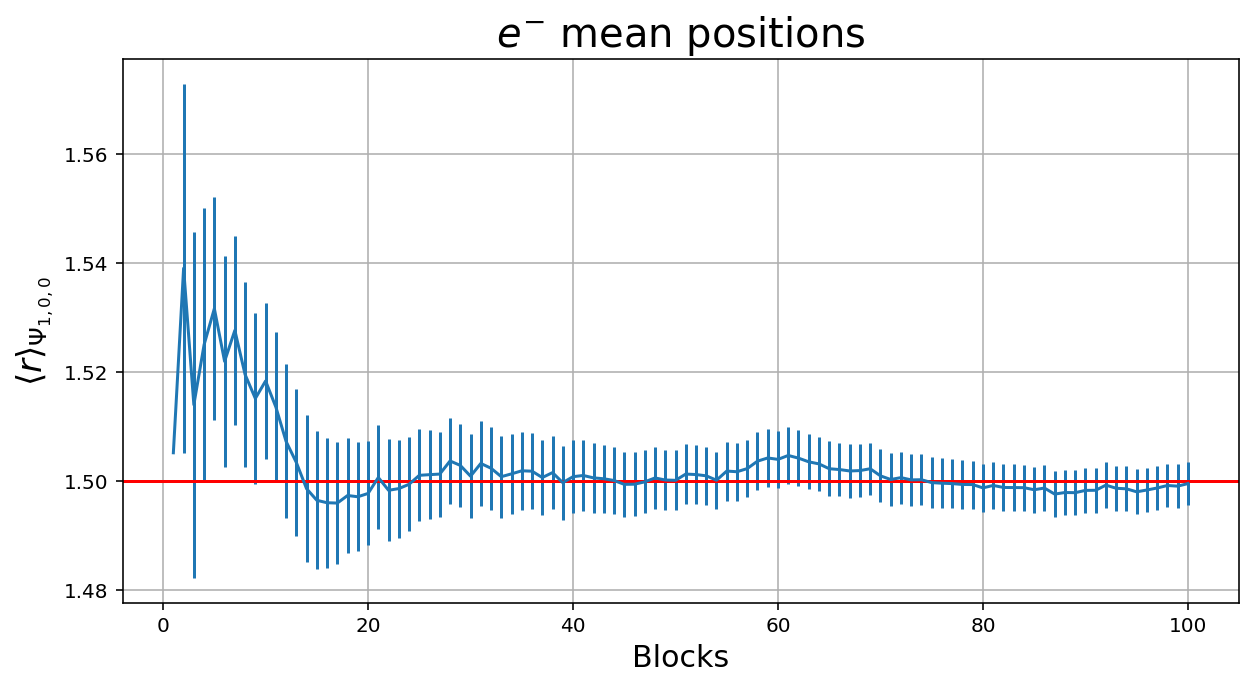

In [3]:
r_GS = np.loadtxt("Esercizio 5/ground state/r_data_blocking.dat")

r_GS = pd.DataFrame(r_GS)

fig, ax = plt.subplots(figsize=(10,5))
ax.errorbar(r_GS[0], r_GS[1], yerr=r_GS[2])
ax.axhline(1.5, color='red')
ax.set_xlabel("Blocks", size = 15)
ax.set_ylabel(r"$\left\langle r \right\rangle_{\Psi_{1,0,0}}$", size = 17)
ax.set_title("$e^{-}$ mean positions", size=20)
ax.grid()

Il grafico riportato mostra come  $\left\langle r \right\rangle_{\Psi_{1,0,0}}$ ottenuto tramite la nostra simulazione sia pienamente compatibile con il valore atteso previsto dalla teoria.

### Primo stato eccitato
Per simulare il primo stato eccitato distribuiamo $|d\vec{r}|$ uniformemente tra $0$ e $3 a_{0}$. Come prima, vengono eseguite $10^{6}$ misure divise su $100$ blocchi. Per il primo blocco l'incertezza statistica è posta pari a $0$.

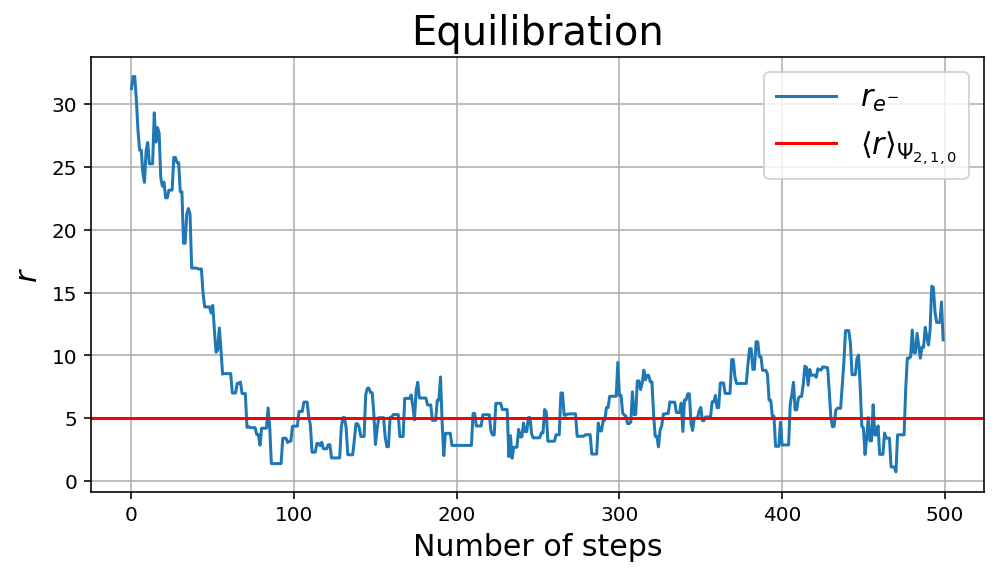

In [4]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

r_eq = pd.read_table("Esercizio 5/primo eccitato/equilibration.dat", header = None)

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(r_eq,label=r"$r_{e^{-}}$")
ax.axhline(5, color='red',label=r"$\left\langle r \right\rangle_{\Psi_{2,1,0}}$")
ax.set_ylabel("$r$", size = 15)
ax.set_xlabel("Number of steps", size = 15)
ax.set_title("Equilibration", size=20)
ax.legend(prop={'size': 15})
ax.grid()

Anche in questo caso, la distanza iniziale dell'elettrone è molto maggiore rispetto a quella di equilibrio. Nel grafico sopra riportato si può osservare il processo di equilibrazione. È anche interessante notare che il sistema è meno stabile rispetto al *GS*, presentando delle oscillazioni maggiori rispetto al valore medio di $r$. 

#### Equilibrio

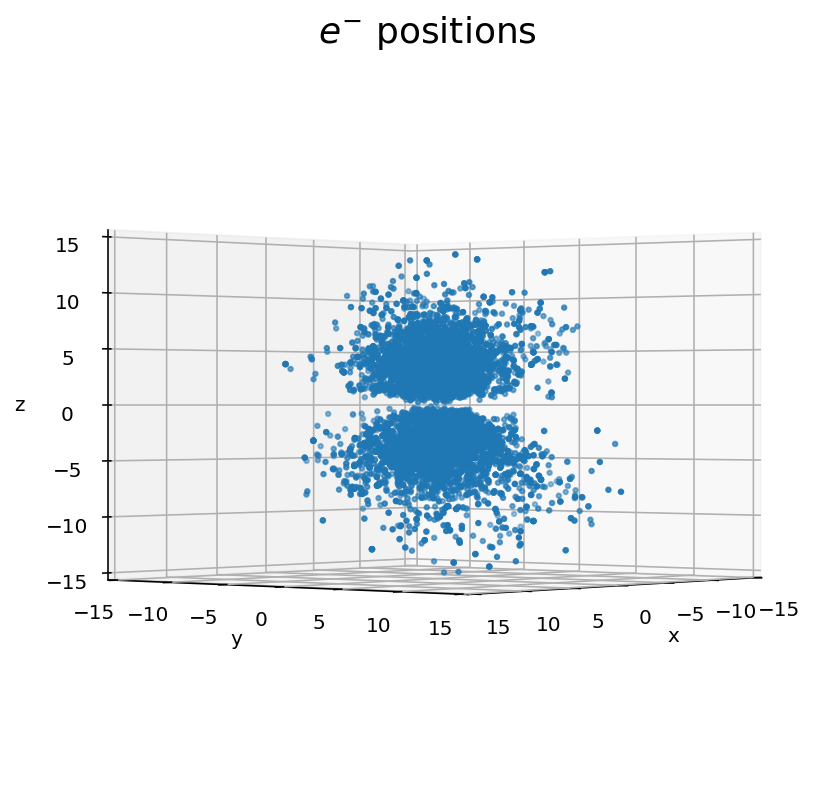

In [5]:
r = np.loadtxt('Esercizio 5/primo eccitato/conf.xyz')

r = pd.DataFrame(r)
    
lim = [-15,15]
fig = plt.figure(figsize=(5,5))
ax = Axes3D(fig)
ax.scatter(r[0], r[1], r[2], marker='.')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.axes.set_xlim(lim)
ax.axes.set_ylim(lim)
ax.axes.set_zlim(lim)
ax.set_title("$e^{-}$ positions", size = 18)
ax.view_init(0,40)
plt.show()

Nell'immagine sopra riportata osserviamo che effettivamente l'elettrone si trova nella regione individuata dall'orbitale *2p*, il che significa che stiamo campionando la distribuzione di probabilità nel modo corretto.

#### Valor medio della posizione

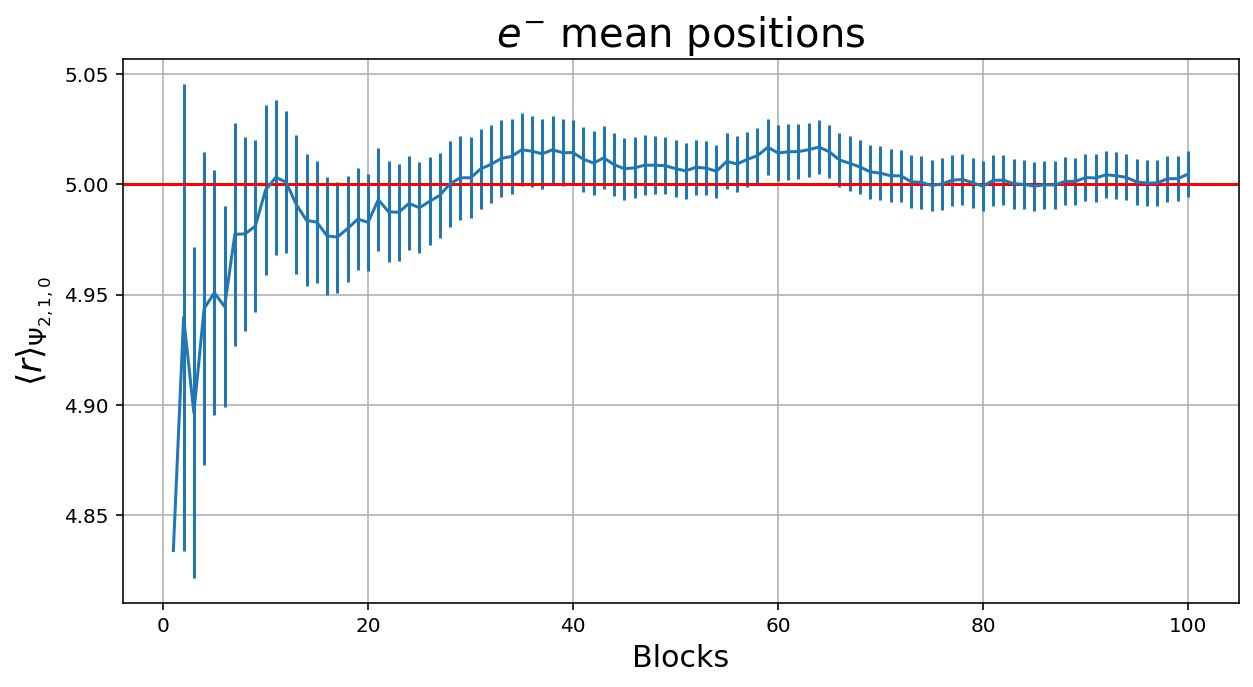

In [6]:
r_GS = np.loadtxt("Esercizio 5/primo eccitato/r_data_blocking.dat")

r_GS = pd.DataFrame(r_GS)

fig, ax = plt.subplots(figsize=(10,5))
ax.errorbar(r_GS[0], r_GS[1], yerr=r_GS[2])
ax.axhline(5, color='red')
ax.set_xlabel("Blocks", size = 15)
ax.set_ylabel(r"$\left\langle r\right\rangle_{\Psi_{2,1,0}}$", size = 17)
ax.set_title("$e^{-}$ mean positions", size=20)
ax.grid()

Il grafico riportato mostra come  $\left\langle r \right\rangle_{\Psi_{2,1,0}}$ ottenuto tramite la nostra simulazione sia pienamente compatibile con il valore atteso previsto dalla teoria.